<a href="https://colab.research.google.com/github/pscabral/IFMASOFTEX_1/blob/main/ModeloPPYoloE_YOLO_1.00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mega.py

from mega import Mega

# Crie uma instância da classe Mega
mega = Mega()

# Cole o link completo do Mega.nz (incluindo a chave)
url = "https://mega.nz/file/tu0GXQzL#BGoVzch2_6s2EEQYLfkwpct1Uq-ZrRL2sHCOY54vohs"

# Use o link completo para fazer o download
mega.download_url(url)

!unzip vegetables.v4i.yolov8.zip

In [ ]:
# Block 1: Install necessary packages
!pip install super-gradients
from PIL import Image
import os
import numpy as np
import torch
import random
import pathlib
from torch.utils.data import Dataset
import json
from torchvision import transforms, utils
import cv2
import matplotlib.pyplot as plt
from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [7]:
# Block 2: Define configuration class
class Config:
    CHECKPOINT_DIR = 'checkpoints'
    EXPERIMENT_NAME = '/content/vegetables'
    DATA_DIR = '../content/vegetables'
    TRAIN_IMAGES_DIR = 'train/images'
    TRAIN_LABELS_DIR = 'train/labels'
    VAL_IMAGES_DIR = 'valid/images'
    VAL_LABELS_DIR = 'valid/labels'
    TEST_IMAGES_DIR = 'test/images'
    TEST_LABELS_DIR = 'test/labels'
    CLASSES = ['apple', 'banana', 'bell_pepper', 'carrot', 'cauliflower', 'chillies', 'cucumber', 'garlic', 'grapes', 'mango', 'mushroom', 'onion', 'orange', 'pear', 'potato', 'promegranate', 'tomato', 'watermelon']
    NUM_CLASSES = len(CLASSES)
    DATALOADER_PARAMS = {'batch_size': 16, 'num_workers': 2}
    MODEL_NAME = 'yolo_nas_l'
    PRETRAINED_WEIGHTS = 'coco'


In [8]:
# Block 3: Instantiate config
config = Config()

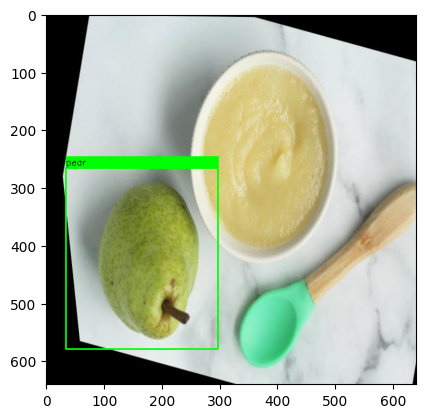

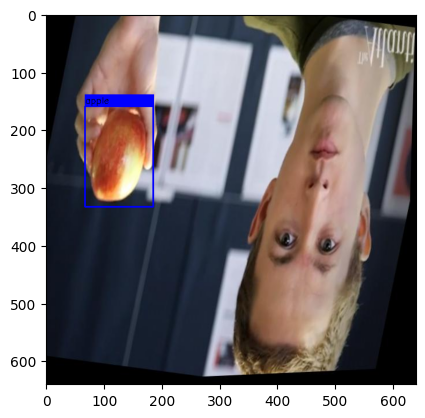

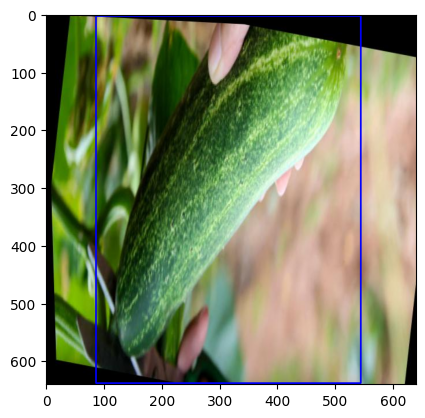

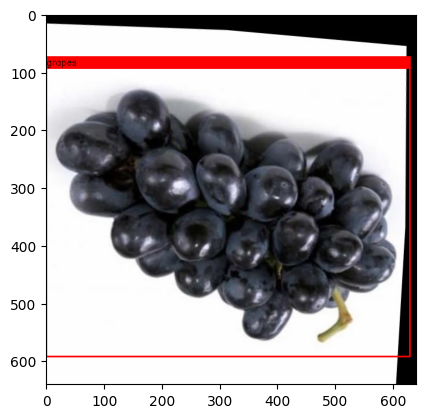

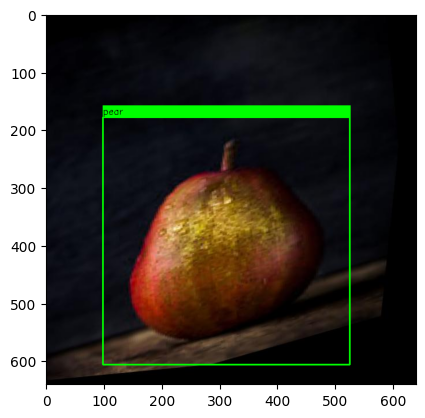

In [10]:
# Block 4: Load and visualize a few random images with labels
for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    demo_label = pathlib.Path(train_labels_dir) / f"{selected_image_file.stem}.txt"
    image = cv2.imread(str(demo_image))
    class_list = config.CLASSES

    # Ensure that the colors list has enough elements for all possible class IDs
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
    if len(colors) < len(class_list):
        # Cycle through the colors if there are more class IDs than colors
        colors *= (len(class_list) // len(colors)) + 1

    height, width, _ = image.shape
    T = []

    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            split = line.split(" ")
            class_id = int(split[0])

            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])
            box = [int((x - 0.5 * w) * width), int((y - 0.5 * h) * height), int(w * width), int(h * height)]

            # Use modulo to prevent index out of range error
            cv2.rectangle(image, box, colors[class_id % len(colors)], 2)
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), colors[class_id % len(colors)], -1)
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 0, 0))

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image = cv2.resize(image, (600, 600))
    plt.show()

In [11]:
# Block 5: Create Trainer instance
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

In [12]:
# Block 6: Create training, validation, and test datasets
train_data = coco_detection_yolo_format_train(
    dataset_params={'data_dir': config.DATA_DIR, 'images_dir': config.TRAIN_IMAGES_DIR, 'labels_dir': config.TRAIN_LABELS_DIR, 'classes': config.CLASSES},
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={'data_dir': config.DATA_DIR, 'images_dir': config.VAL_IMAGES_DIR, 'labels_dir': config.VAL_LABELS_DIR, 'classes': config.CLASSES},
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={'data_dir': config.DATA_DIR, 'images_dir': config.TEST_IMAGES_DIR, 'labels_dir': config.TEST_LABELS_DIR, 'classes': config.CLASSES},
    dataloader_params=config.DATALOADER_PARAMS
)

[2023-11-23 17:55:50] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1775/1775 [00:00<00:00, 5343.73it/s]
[2023-11-23 17:55:51] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 256/256 [00:00<00:00, 5505.89it/s]
[2023-11-23 17:55:51] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 129/129 [00:00<00:00, 4980.07it/s]


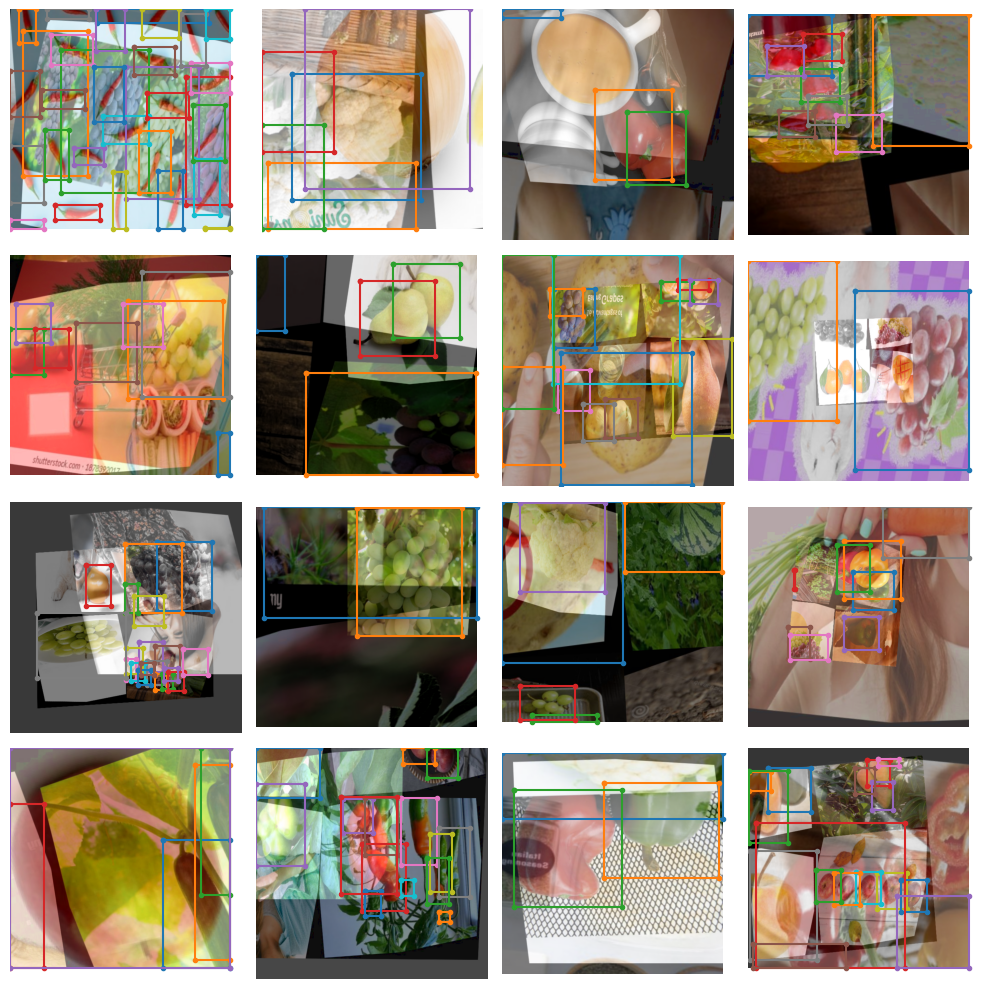

In [13]:
# Block 7: Plot dataset
train_data.dataset.plot()

In [14]:
# Block 8: Load YOLO-NAS model
model = models.get(config.MODEL_NAME, num_classes=config.NUM_CLASSES, pretrained_weights=config.PRETRAINED_WEIGHTS)

[2023-11-23 17:57:01] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:09<00:00, 29.7MB/s]


In [16]:
# Block 9: Define training parameters
train_params = {
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-5,
    "lr_warmup_epochs": 5,
    "initial_lr": 3e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(use_static_assigner=False, num_classes=config.NUM_CLASSES, reg_max=16),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        # Add more metrics here
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
# Block 10: Train the model
trainer.train(model=model, training_params=train_params, train_loader=train_data, valid_loader=val_data)

[2023-11-23 17:57:58] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231123_175758_455970`
[2023-11-23 17:57:58] INFO - sg_trainer.py - Checkpoints directory: /content/vegetables/RUN_20231123_175758_455970
[2023-11-23 17:57:58] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /content/vegetables/RUN_20231123_175758_455970/console_Nov23_17_57_58.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:107: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/super_gradients/training/sg_trainer/sg_trainer.py:1686: UserWarning: Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
  

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.124
│   ├── Ppyoloeloss/loss_iou = 0.5678
│   ├── Ppyoloeloss/loss_dfl = 0.761
│   └── Ppyoloeloss/loss = 3.4528
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.1203
    ├── Ppyoloeloss/loss_iou = 0.5241
    ├── Ppyoloeloss/loss_dfl = 0.7302
    ├── Ppyoloeloss/loss = 3.3746
    ├── Precision@0.50 = 0.0344
    ├── Recall@0.50 = 0.1159
    ├── Map@0.50 = 0.0388
    └── F1@0.50 = 0.0277



Validating epoch 1: 100%|██████████| 16/16 [03:03<00:00, 11.45s/it]
[2023-11-23 20:39:07] INFO - base_sg_logger.py - Checkpoint saved in /content/vegetables/RUN_20231123_175758_455970/ckpt_best.pth
[2023-11-23 20:39:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.22337129712104797


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.666
│   │   ├── Epoch N-1      = 2.124  (↘ -0.458)
│   │   └── Best until now = 2.124  (↘ -0.458)
│   ├── Ppyoloeloss/loss_iou = 0.4822
│   │   ├── Epoch N-1      = 0.5678 (↘ -0.0856)
│   │   └── Best until now = 0.5678 (↘ -0.0856)
│   ├── Ppyoloeloss/loss_dfl = 0.6589
│   │   ├── Epoch N-1      = 0.761  (↘ -0.1022)
│   │   └── Best until now = 0.761  (↘ -0.1022)
│   └── Ppyoloeloss/loss = 2.807
│       ├── Epoch N-1      = 3.4528 (↘ -0.6458)
│       └── Best until now = 3.4528 (↘ -0.6458)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5976
    │   ├── Epoch N-1      = 2.1203 (↘ -0.5227)
    │   └── Best until now = 2.1203 (↘ -0.5227)
    ├── Ppyoloeloss/loss_iou = 0.6302
    │   ├── Epoch N-1      = 0.5241 (↗ 0.1061)
    │   └── Best until now = 0.5241 (↗ 0.1061)
    ├── Ppyoloeloss/loss_dfl = 0.825
    │   ├── Epoch N-1      = 0.7302 (↗ 0.0949)
    │   └── Best until now = 0.7302 (↗ 0.0949)
    ├── Ppyoloeloss/loss = 3.05

Train epoch 2:   2%|▏         | 2/110 [01:55<1:39:48, 55.45s/it, PPYoloELoss/loss=2.61, PPYoloELoss/loss_cls=1.43, PPYoloELoss/loss_dfl=0.675, PPYoloELoss/loss_iou=0.514, gpu_mem=0]